<link rel="stylesheet" href="https://use.typekit.net/dvn1law.css">
<style>        
@font-face {
font-family:"futura-pt-bold";
src:url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/l?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("woff2"),url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/d?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("woff"),url("https://use.typekit.net/af/053fc9/00000000000000003b9af1e4/27/a?primer=7cdcb44be4a7db8877ffa5c0007b8dd865b3bbc383831fe2ea177f62257a9191&fvd=n7&v=3") format("opentype");
font-display:auto;font-style:normal;font-weight:700;font-stretch:normal;
}
</style>
<div style="display: flex; margin: 0px; padding-top: 1.5rem; padding-bottom: 1.5rem; font-family: futura-pt, 'Tahoma', 'Segoe UI', Geneva, Verdana, sans-serif;">
    <span style="margin-right: 15px; padding-right: 2rem; background-color: #3b6d48;"></span>
    <div style="margin-bottom: auto; margin-top: auto; margin-right: auto; padding-right: 15px;">
        <div style="margin: 0; padding-top: 0.2rem; padding-bottom: 3.3rem; letter-spacing: 0.15rem; color: #a6ce37; font-weight: bold; font-size: 3rem; font: futura-pt-bold"> CEOS Analytics Lab</div>
        <div style="margin: 0; color: #469ab9; font-weight: bold; font-size: 1.5rem;">Welcome to the CEOS Analytics Lab!</div>
        <div style="margin: 0; padding-bottom: 0.2rem; color: #474c38; font-size: 1.25rem;"><span>TBD</span><span>| </span><span style="color: #3b6d48; font-weight: bold;">SAVI Index</span></div>
        <hr style="border: 1px solid #474c38;">
    </div>
    <div style="margin-top: auto; margin-bottom: auto; margin-left: auto; padding-left: 15px;">
        <div><img style="vertical-align: middle; padding: 0.5rem; width: 300px; height: auto;" src="https://ceos.org/document_management/Communications/CEOS-Logos/CEOS_logo_colour_no_text-small.png" /></div>
    </div>
</div>

In [6]:
import sys, os
sys.path.append(os.path.expanduser('../../../../scripts'))
from easi_tools import notebook_utils
from datacube.utils.aws import configure_s3_access
cluster, client = notebook_utils.initialize_dask(use_gateway=False)
os.environ['USE_PYGEOS'] = '0'
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
from easi_tools import EasiDefaults
# from easi_tools import notebook_utils

/home/jovyan/cal-notebooks/examples/ceos-notebooks/Spectral Products/spectral/../../../../scripts/easi_tools/notebook_utils.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35905 instead
  warnings.warn(


Landsat Soil Adjusted Vegetation Index (SAVI) is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low. 



### Formula

The index is given as:


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a2ec4689e5b4c101db303bcc741c63a20187e6f6)


- In Landsat 4-7, SAVI = ((Band 4 – Band 3) / (Band 4 + Band 3 + 0.5)) * (1.5).

- In Landsat 8-9, SAVI = ((Band 5 – Band 4) / (Band 5 + Band 4 + 0.5)) * (1.5).
  



  

# References:

-  Huete, A.R (August 1988). "A soil-adjusted vegetation index (SAVI)". Remote Sensing of Environment. 25 (3): 295–309. doi:10.1016/0034-4257(88)90106-X.

- https://www.streambatch.io/knowledge/savi-from-first-principles  

- https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index  

- https://www.geo.university/pages/savi-and-ndvi-spectral-index-comparison


### Definition

In [7]:
def SAVI(ds, L=0.5, normalize=True):
    """
    The Soil-Adjusted Vegetation Index (SAVI) monitors photosyntehtic vegetation, 
    correcting for soil differences.
    Greater values generally indicate more photosynthetic vegetation.
    For Landsat data, returned values should be in the range [-1,1] if `normalize == True`.
    If `normalize == False`, returned values should be in the range [-1-L,1+L].
    """
    savi = (ds.nir - ds.red) / (ds.nir + ds.red + L) * (1 + L)
    if normalize:
        savi.values = np.interp(savi.values, (-1-L, 1+L), (-1, 1))
    return savi

# Invocation of the Index

#### Load Data

In [8]:
import datacube
dc = datacube.Datacube(app = "SAVI Spectral")

landsat_dataset = dc.load(latitude =(37.02, 37.12) ,
                          longitude =  (-76.55, -76.34) ,
                          time = ('2015-1-1', '2015-12-31'),
                          product = "landsat8_c2l2_sr",
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'pixel_qa'],
                          output_crs = 'EPSG:6933',
                          resolution = (-30,30),
                        dask_chunks = {'time':1}
                         ) 

#### Create Composite

In [9]:
def median_composite(dataset, clean_mask):
    cleaned_dataset = dataset.where(clean_mask)
    composite = cleaned_dataset.median('time', skipna=True)
    return composite

In [10]:
from landsat_utils import landsat_qa_clean_mask

cloud_mask             = landsat_qa_clean_mask(landsat_dataset,
                                               platform="LANDSAT_8", 
                                               collection="c2",
                                               level="l2")

land_mask =  landsat_qa_clean_mask(landsat_dataset,
                                                platform="LANDSAT_8", 
                                                collection="c2",
                                                level="l2",
                                                cover_types=['clear'])

land_and_water_dataset = landsat_dataset.where(cloud_mask)
land_dataset = landsat_dataset.where(land_mask)

land_and_water_composite =   median_composite(land_and_water_dataset, cloud_mask).persist()
land_composite = median_composite(land_dataset, land_mask).persist()



### Plot Composite

In [11]:
import numpy as np
rgb_arr = np.dstack([land_and_water_composite.red.values,land_and_water_composite.green.values,land_and_water_composite.blue.values])

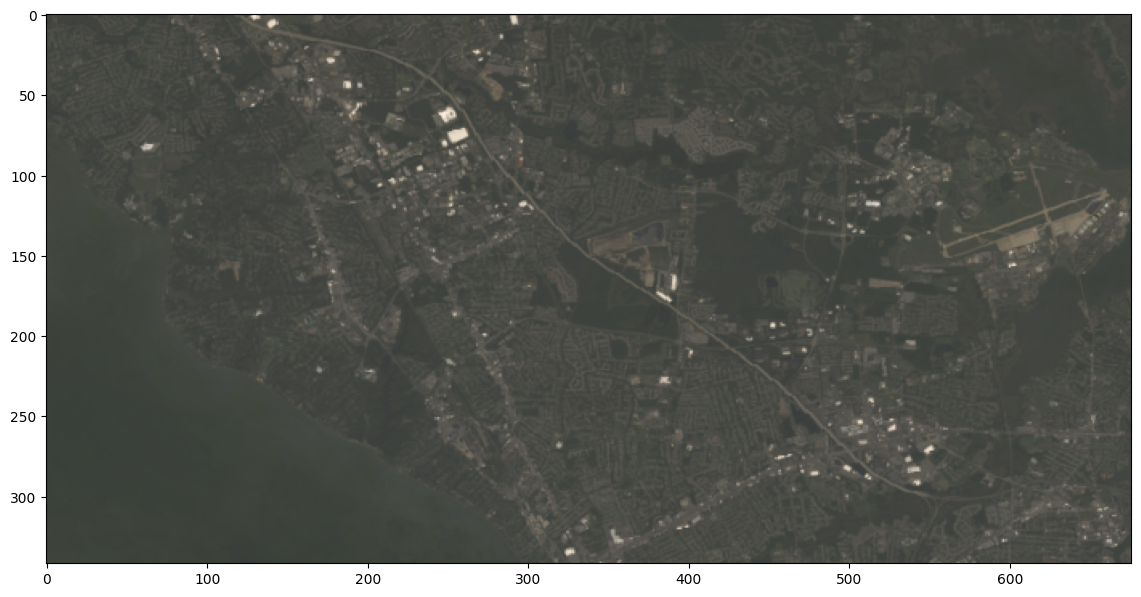

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 8))
plt.imshow(rgb_arr/rgb_arr.max())

### Run SAVI on Composite

In [13]:
ds_SAVI = SAVI(land_and_water_composite)

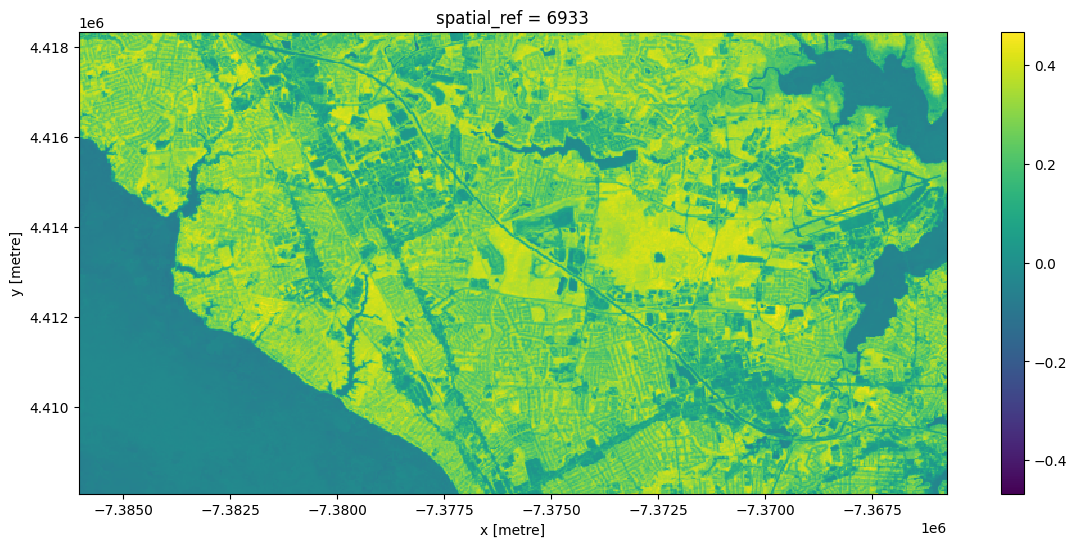

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 6))
ds_SAVI.plot.imshow(cmap = "viridis")

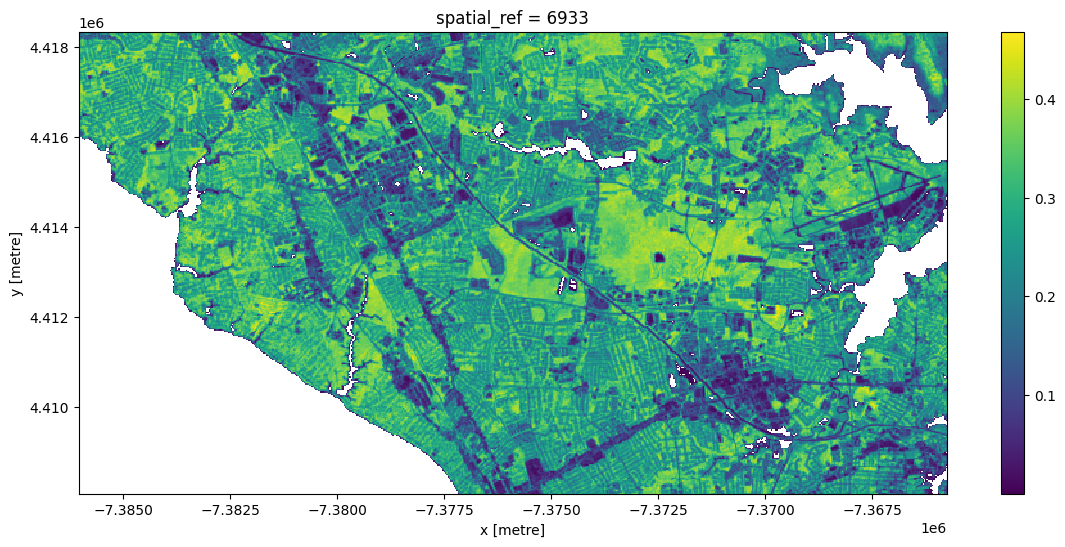

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 6))
ds_SAVI.where(ds_SAVI > 0).plot.imshow(cmap = "viridis")